In [1]:
from warnings import simplefilter

simplefilter(action="ignore")

## Try out geopandas

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plz_shape_df = gpd.read_file('data/plz-5stellig.shp', dtype={'plz': str})
plz_region_df = pd.read_csv(
    'data/zuordnung_plz_ort.csv', sep=',', dtype={'plz': str}
)
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)
germany_df.drop(["note", "osm_id"], axis=1, inplace=True)
germany_df.head(1)

,plz,einwohner,qkm,geometry,ags,ort,landkreis,bundesland
0,81248,121,1.984763,"POLYGON ((11.39468 48.14729, 11.39490 48.14780...",9162000,München,NaN,Bayern


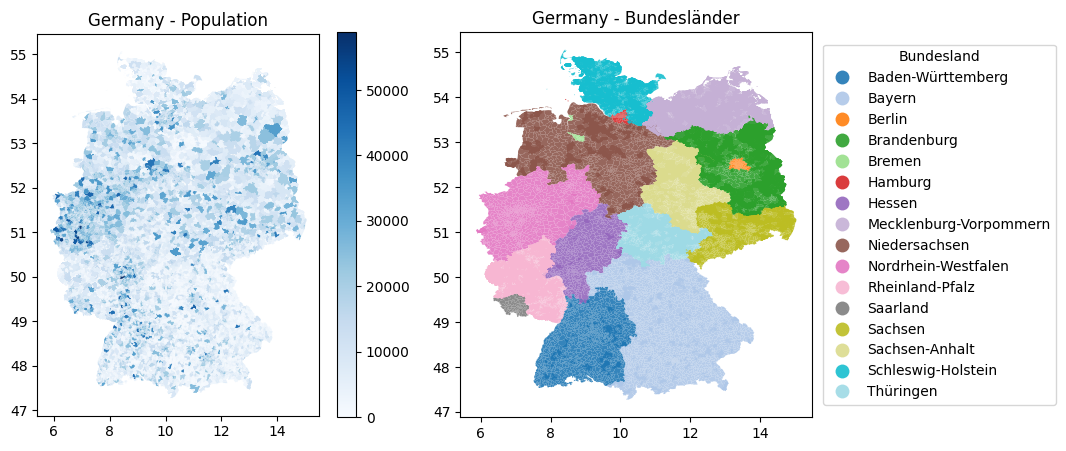

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[0] = germany_df.plot(
                        ax=ax[0],
                        column="einwohner",
                        categorical=False,
                        legend=True,
                        alpha=0.99,
                        cmap ='Blues',
)

ax[1] = germany_df.plot(
                        ax=ax[1],
                        column='bundesland',
                        categorical=True,
                        legend=True, 
                        legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.01, 0.5), 'loc': "center left"},
                        cmap='tab20',
                        alpha=0.9,
                        aspect=None,
                    )

ax[0].set(title='Germany - Population')
ax[1].set(title='Germany - Bundesländer')

plt.show()

## Plot salamanders data

In [7]:
raw_data_path = "data/Bsal_Standorte_06072022.MV_110722.xlsx"
bsal_df = pd.read_excel(raw_data_path)
bsal_df.head(1)

,Standort,Infektionstyp,Remarks,Anzahl Arten,Feuersalamander,Bergmolch,Fadenmolch,Teichmolch,Kammmolch,Gelbbauchunke,Grasfrosch,Erdkröte,Geburtshelferkröte,Grünfrösche,Jahr,X_Coord,Y_Coord
0,Bunderbos (Massensterben),Erstinfektion,,1,1,0,0,0,0,0,0,0,0,0,2010,5.747381,50.9131


In [8]:
from shapely.geometry import Point

coords = [Point(row) for row in zip(bsal_df["X_Coord"], bsal_df["Y_Coord"])]
coords_plot = gpd.GeoDataFrame(geometry=coords)

In [9]:
new_df = germany_df.dissolve(by='bundesland', aggfunc={"einwohner": "sum"},)

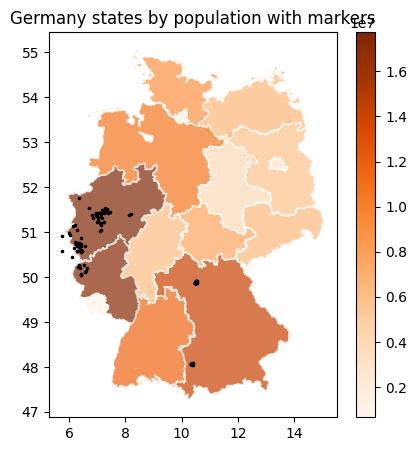

In [10]:
plt.figure(figsize=(5,5))

coords_plot.plot(ax=plt.gca(), color='k', marker=".", markersize=10, zorder=2)

new_df.plot(
    ax=plt.gca(),
    column='einwohner',
    categorical=False,
    legend=True,
    # legend_kwds={'title':'Bundesland', 'bbox_to_anchor': (1.01, 0.5), 'loc': "center left"},
    cmap='Oranges',
    alpha=0.7,
    edgecolor='white'
)

plt.gca().set(title='Germany states by population with markers')
plt.show()

## Bsal infections analysis

In [11]:
bsal_df.loc[bsal_df["Infektionstyp"] == "erstinfektion", "Infektionstyp"] = "Erstinfektion"
bsal_df_grouped = bsal_df.groupby(["Jahr", "Infektionstyp"], group_keys=False).agg({'Anzahl Arten': 'sum', 'Feuersalamander': 'sum'}).reset_index()
bsal_df_grouped["Others"] = bsal_df_grouped["Anzahl Arten"] - bsal_df_grouped["Feuersalamander"]
bsal_df_grouped.head(2)

,Jahr,Infektionstyp,Anzahl Arten,Feuersalamander,Others
0,2004,Erstinfektion,1,1,0
1,2010,Erstinfektion,1,1,0


In [12]:
bsal_df_grouped.rename({"Jahr": "Year", "Infektionstyp": "Infection type"}, inplace=True, axis=1)
bsal_df_grouped["Infection type"] = bsal_df_grouped["Infection type"].map({"Erstinfektion": "First infection", "Fraglich": "Unknown"})

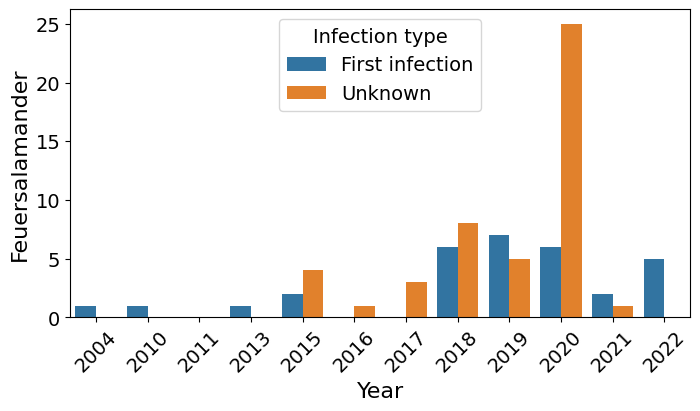

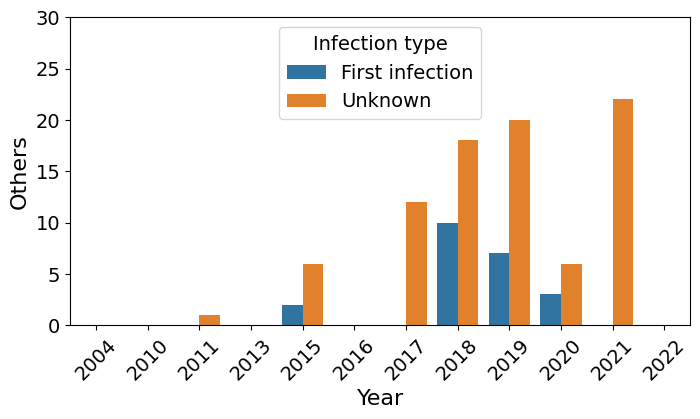

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(data=bsal_df_grouped, x="Year", y="Feuersalamander", hue="Infection type")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Feuersalamander", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, title="Infection type", title_fontsize=14, loc='upper center')
plt.savefig(f"plots_presentation/infection_distribution_feuersalamander.svg", format='svg', bbox_inches="tight", pad_inches=0)

plt.figure(figsize=(8,4))
sns.barplot(data=bsal_df_grouped, x="Year", y="Others", hue="Infection type")
plt.ylim(0, 30)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Others", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, title="Infection type", title_fontsize=14, loc='upper center')
plt.savefig(f"plots_presentation/infection_distribution_others.svg", format='svg', bbox_inches="tight", pad_inches=0)

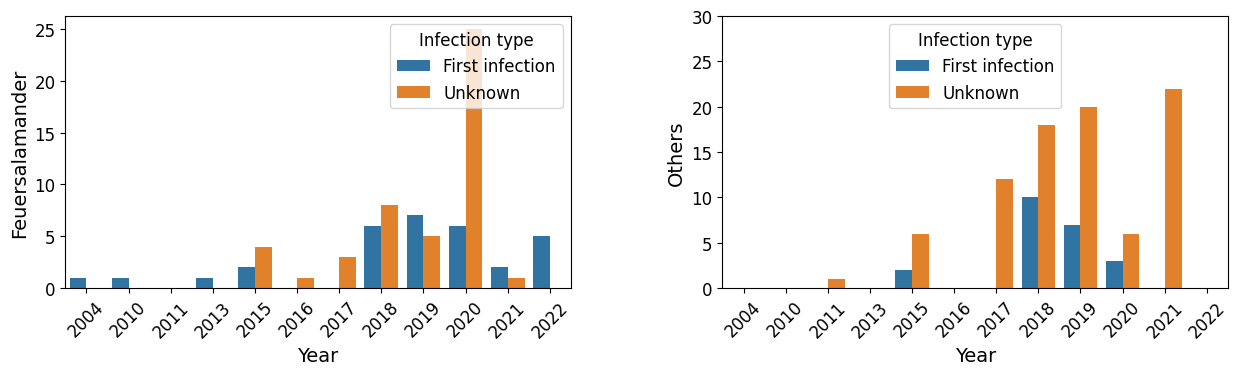

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.barplot(data=bsal_df_grouped, x="Year", y="Feuersalamander", hue="Infection type")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Feuersalamander", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title="Infection type", title_fontsize=12)
plt.subplot(1,2,2)
sns.barplot(data=bsal_df_grouped, x="Year", y="Others", hue="Infection type")
plt.ylim(0, 30)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Others", fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title="Infection type", title_fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

## Plot Feuersalamander data by year and Infection Type

In [24]:
plz_shape_df = gpd.read_file('data/plz-5stellig.shp', dtype={'plz': str})
plz_region_df = pd.read_csv(
    'data/zuordnung_plz_ort.csv', sep=',', dtype={'plz': str}
)
germany_df = pd.merge(
    left=plz_shape_df, 
    right=plz_region_df, 
    on='plz',
    how='inner'
)
germany_df.drop(["note", "osm_id"], axis=1, inplace=True)

germany_df = germany_df.dissolve(by='bundesland', aggfunc={"einwohner": "sum"},)

bunderlaender = [
    'Baden-Württemberg', 'Bayern', 'Hessen','Nordrhein-Westfalen',
    'Rheinland-Pfalz', 'Saarland','Thüringen']
germany_df = germany_df.reset_index()[germany_df.reset_index()["bundesland"].isin(bunderlaender)]

germany_df.head(1)

,bundesland,geometry,einwohner
0,Baden-Württemberg,"MULTIPOLYGON (((7.64606 47.56072, 7.64650 47.5...",11504792


In [25]:
bsal_df = pd.read_excel("data/Bsal_Standorte_06072022.MV_110722.xlsx")

coords = [Point(row) for row in zip(bsal_df["X_Coord"], bsal_df["Y_Coord"])]
bsal_df = gpd.GeoDataFrame(data=bsal_df, geometry=coords)

bsal_df.head(1)

,Standort,Infektionstyp,Remarks,Anzahl Arten,Feuersalamander,Bergmolch,Fadenmolch,Teichmolch,Kammmolch,Gelbbauchunke,Grasfrosch,Erdkröte,Geburtshelferkröte,Grünfrösche,Jahr,X_Coord,Y_Coord,geometry
0,Bunderbos (Massensterben),Erstinfektion,,1,1,0,0,0,0,0,0,0,0,0,2010,5.747381,50.9131,POINT (5.74738 50.91310)


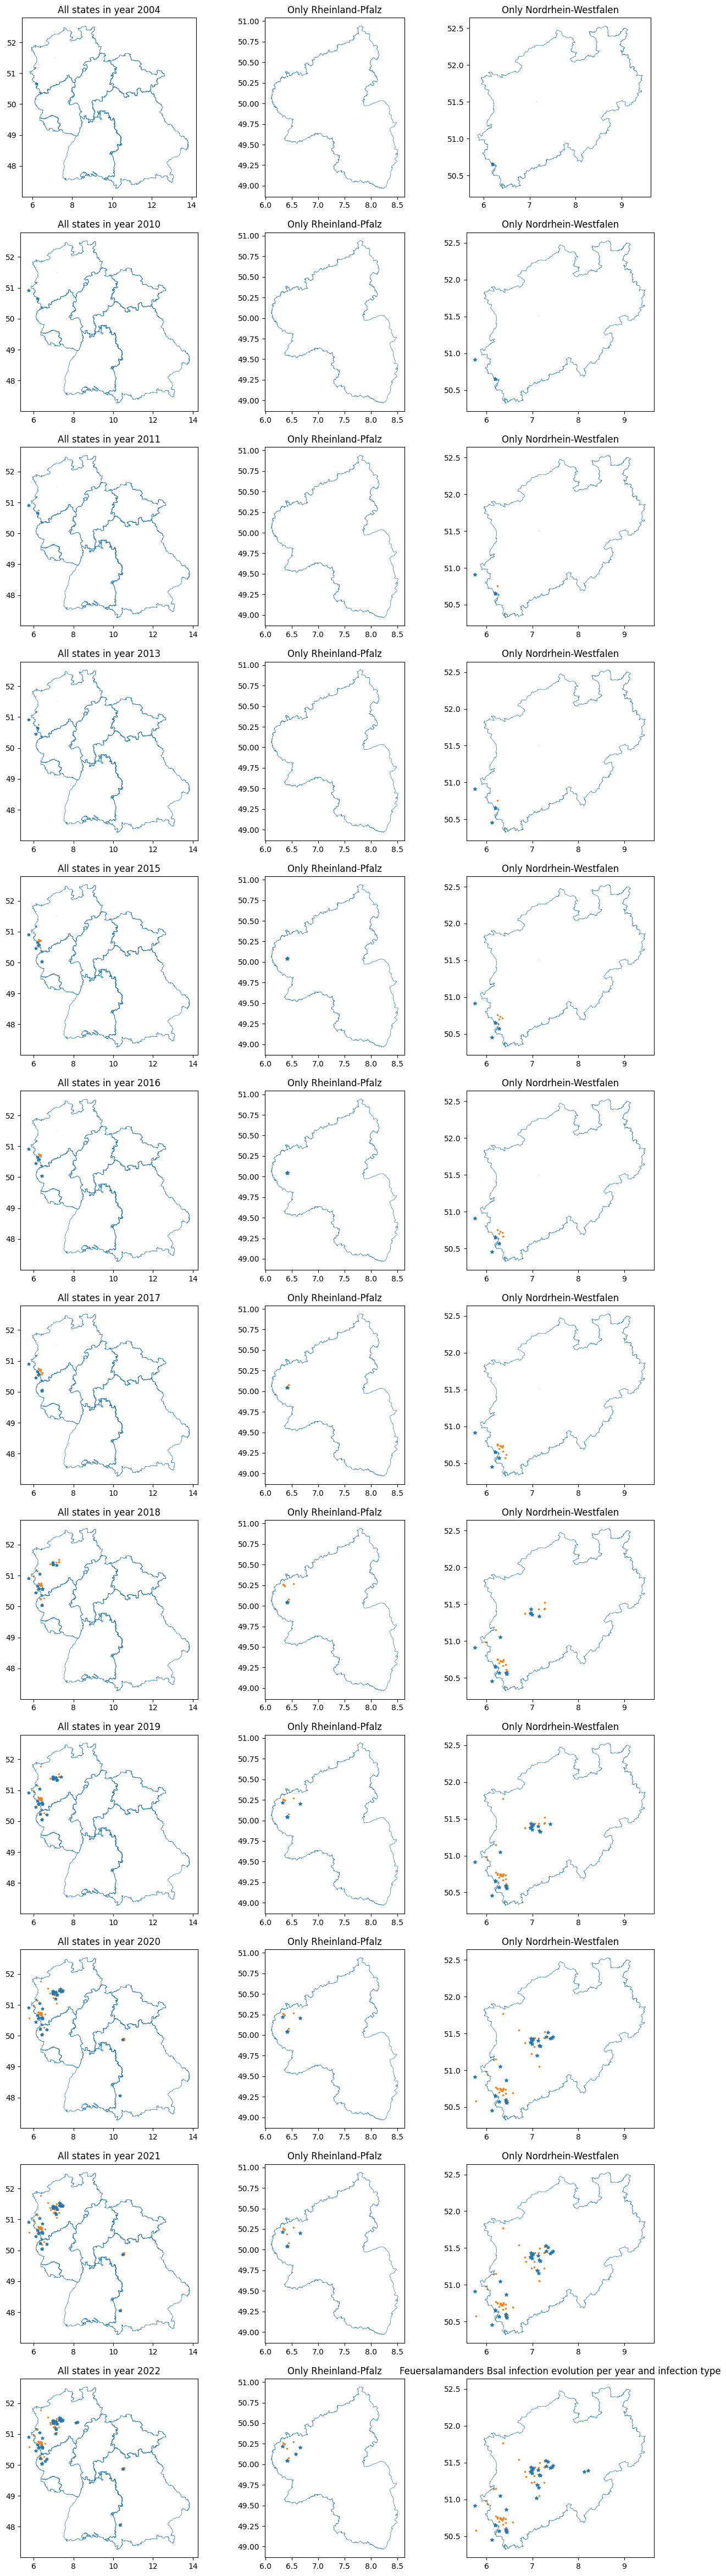

In [26]:
fig, axs = plt.subplots(nrows=bsal_df["Jahr"].nunique(), ncols=3, figsize=(15, 5 * bsal_df["Jahr"].nunique()))

for idx, year in enumerate(bsal_df.sort_values("Jahr")["Jahr"].unique()):
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 0],
        marker="*",
        markersize=15,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 0],
        marker=".",
        markersize=7,
        zorder=2)
    germany_df.boundary.plot(
        ax=axs[idx, 0],
        linewidth=0.5
    )
    axs[idx, 0].set(title=f'All states in year {year}')


    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 1],
        marker="*",
        markersize=20,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 1],
        marker=".",
        markersize=10,
        zorder=2)
    germany_df[germany_df["bundesland"] == "Rheinland-Pfalz"].boundary.plot(
        ax=axs[idx, 1],
        linewidth=0.5
    )
    axs[idx, 1].set(title='Only Rheinland-Pfalz')

    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 2],
        marker="*",
        markersize=20,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] <= year)].plot(
        ax=axs[idx, 2],
        marker=".",
        markersize=10,
        zorder=2)
    germany_df[germany_df["bundesland"] == "Nordrhein-Westfalen"].boundary.plot(
        ax=axs[idx, 2],
        linewidth=0.5
    )
    axs[idx, 2].set(title='Only Nordrhein-Westfalen')

plt.title("Feuersalamanders Bsal infection evolution per year and infection type")
plt.show()

In [27]:
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [28]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

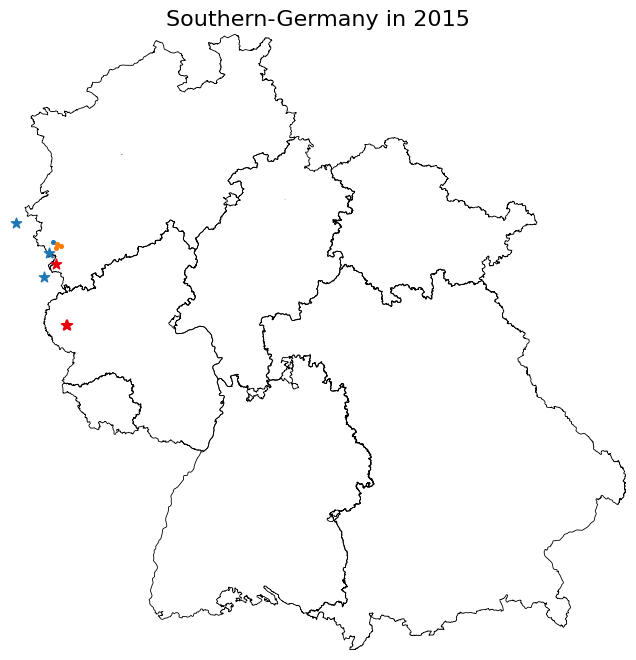

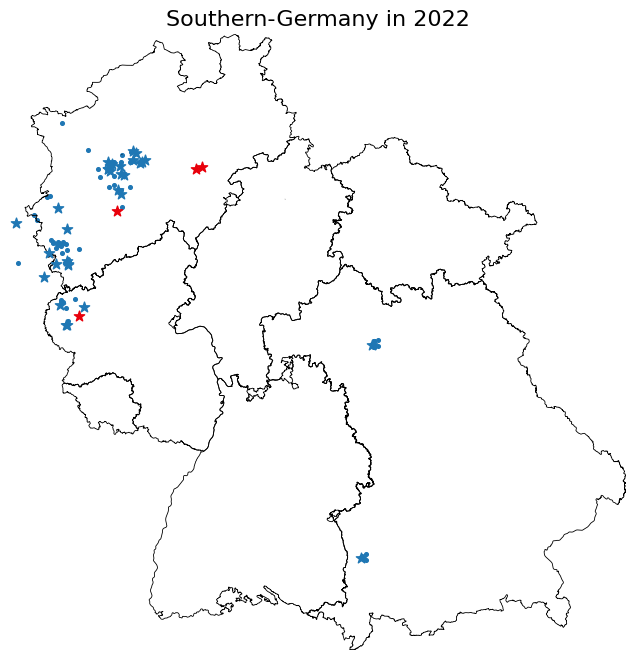

In [65]:
for year in [2015, 2022]:
    plt.figure(figsize=(8,8))
    mult = 4
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["Jahr"] < year)].plot(
        ax=plt.gca(),
        marker="*",
        color=sns.color_palette("tab10")[0],
        markersize=15 * mult,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["Jahr"] < year)].plot(
        ax=plt.gca(),
        marker=".",
        color=sns.color_palette("tab10")[0],
        markersize=7 * mult,
        zorder=2)
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["Jahr"] == year)].plot(
        ax=plt.gca(),
        marker="*",
        color=sns.color_palette("bright")[3],
        markersize=15 * mult,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["Jahr"] == year)].plot(
        ax=plt.gca(),
        marker=".",
        color=sns.color_palette("bright")[1],
        markersize=7 * mult,
        zorder=2)
    germany_df.boundary.plot(
        ax=plt.gca(),
        linewidth=0.6,
        edgecolor='black'
        )
    minx, miny, maxx, maxy = germany_df.total_bounds
    plt.xlim(minx-0.2, maxx)
    plt.ylim(miny, maxy)
    plt.axis("off")
    plt.title(f"Southern-Germany in {year}", fontsize=16)
    plt.savefig(f"plots_presentation/dataset_{year}.svg", format='svg', bbox_inches="tight", pad_inches=0)

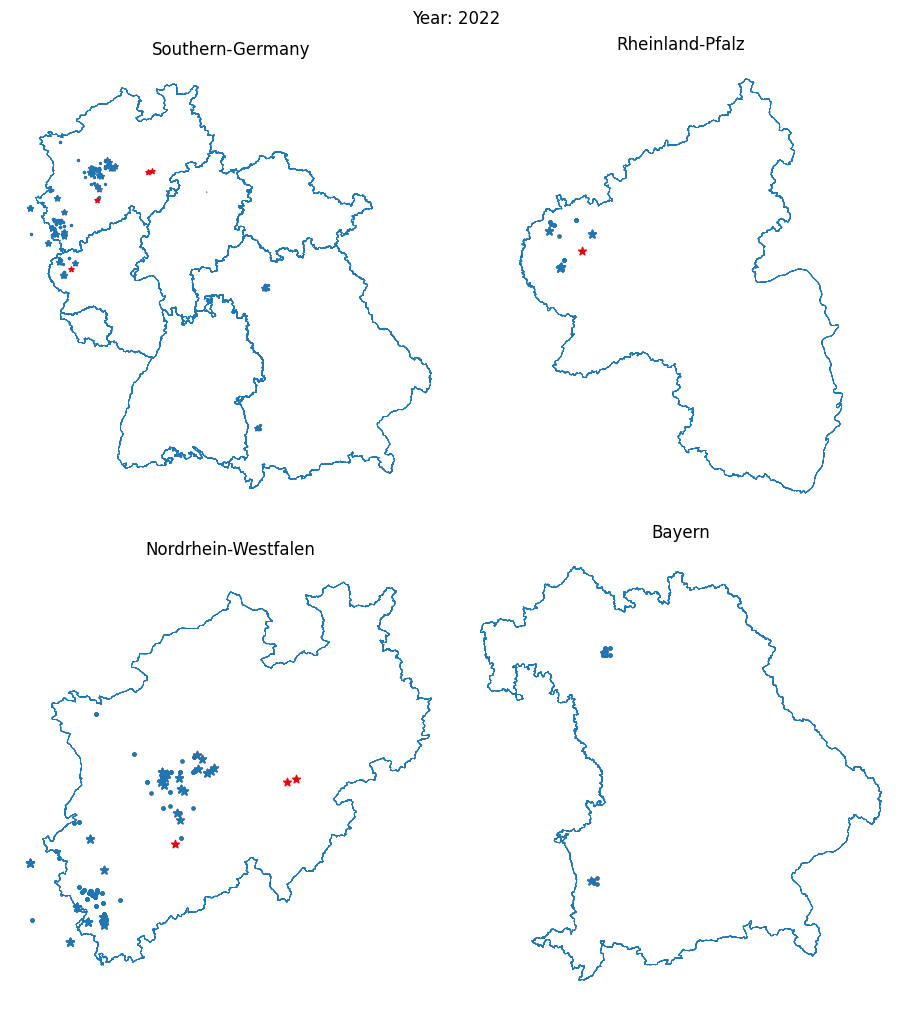

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 10), constrained_layout=True)

for idx, year in enumerate(bsal_df.sort_values("Jahr")["Jahr"].unique()):
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["Jahr"] < year)].plot(
        ax=axs[0, 0],
        marker="*",
        color=sns.color_palette("tab10")[0],
        markersize=15,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["Jahr"] < year)].plot(
        ax=axs[0, 0],
        marker=".",
        color=sns.color_palette("tab10")[0],
        markersize=7,
        zorder=2)
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["Jahr"] == year)].plot(
        ax=axs[0, 0],
        marker="*",
        color=sns.color_palette("bright")[3],
        markersize=15,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["Jahr"] == year)].plot(
        ax=axs[0, 0],
        marker=".",
        color=sns.color_palette("bright")[1],
        markersize=7,
        zorder=2)
    germany_df.boundary.plot(
        ax=axs[0, 0],
        linewidth=0.5
    )
    axs[0, 0].set(title=f'Southern-Germany')
    axs[0, 0].set_axis_off()


    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[0, 1],
        marker="*",
        color=sns.color_palette("tab10")[0],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[0, 1],
        marker=".",
        color=sns.color_palette("tab10")[0],
        markersize=20,
        zorder=2)
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[0, 1],
        marker="*",
        color=sns.color_palette("bright")[3],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] < 50.3) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[0, 1],
        marker=".",
        color=sns.color_palette("bright")[1],
        markersize=20,
        zorder=2)
    germany_df[germany_df["bundesland"] == "Rheinland-Pfalz"].boundary.plot(
        ax=axs[0, 1],
        linewidth=0.5
    )
    axs[0, 1].set(title='Rheinland-Pfalz')
    axs[0, 1].set_axis_off()

    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[1, 0],
        marker="*",
        color=sns.color_palette("tab10")[0],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[1, 0],
        marker=".",
        color=sns.color_palette("tab10")[0],
        markersize=20,
        zorder=2)
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[1, 0],
        marker="*",
        color=sns.color_palette("bright")[3],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] < 9) & (bsal_df["Y_Coord"] > 50.3) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[1, 0],
        marker=".",
        color=sns.color_palette("bright")[1],
        markersize=20,
        zorder=2)
    germany_df[germany_df["bundesland"] == "Nordrhein-Westfalen"].boundary.plot(
        ax=axs[1, 0],
        linewidth=0.5
    )
    axs[1, 0].set(title='Nordrhein-Westfalen')
    axs[1, 0].set_axis_off()

    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] > 10) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[1, 1],
        marker="*",
        color=sns.color_palette("tab10")[0],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] > 10) & (bsal_df["Jahr"] < year)].plot(
        ax=axs[1, 1],
        marker=".",
        color=sns.color_palette("tab10")[0],
        markersize=20,
        zorder=2)
    bsal_df[(bsal_df["Infektionstyp"] == "Erstinfektion") & (bsal_df["X_Coord"] > 10) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[1, 1],
        marker="*",
        color=sns.color_palette("bright")[3],
        markersize=35,
        zorder=3)
    bsal_df[(bsal_df["Infektionstyp"] == "Fraglich") & (bsal_df["X_Coord"] > 10) & (bsal_df["Jahr"] == year)].plot(
        ax=axs[1, 1],
        marker=".",
        color=sns.color_palette("bright")[1],
        markersize=20,
        zorder=2)
    germany_df[germany_df["bundesland"] == "Bayern"].boundary.plot(
        ax=axs[1, 1],
        linewidth=0.5
    )
    axs[1, 1].set(title='Bayern')
    axs[1, 1].set_axis_off()

    fig.suptitle(f"Year: {year}", fontsize=12)
    plt.savefig(f"plots_presentation/{year}.png", format='png', transparent=True)
    plt.subplots_adjust(wspace=0, hspace=0)

plt.show()